In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from scipy.optimize import minimize

### Import data

In [2]:
# Import data
data_7_16_2025 = pd.read_csv('daily-treasury-rates.csv')

In [3]:
data_7_16_2025

,Date,1 Mo,1.5 Mo,2 Mo,3 Mo,4 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr
0,7/16/2025,4.36,4.40,4.45,4.41,4.42,4.31,4.08,3.88,3.86,3.99,4.21,4.46,5.01,5.01
1,7/15/2025,4.36,4.40,4.46,4.42,4.43,4.33,4.12,3.95,3.93,4.05,4.26,4.50,5.02,5.01
2,7/14/2025,4.37,4.41,4.46,4.42,4.42,4.31,4.08,3.90,3.86,3.98,4.19,4.43,4.97,4.97
3,7/11/2025,4.37,4.39,4.47,4.41,4.42,4.31,4.09,3.90,3.86,3.99,4.19,4.43,4.96,4.96
4,7/10/2025,4.36,4.39,4.47,4.42,4.42,4.31,4.07,3.86,3.82,3.93,4.12,4.35,4.87,4.86
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129,1/8/2025,4.41,NaN,4.34,4.35,4.31,4.25,4.19,4.28,4.31,4.45,4.56,4.67,4.97,4.91
130,1/7/2025,4.42,NaN,4.35,4.35,4.31,4.24,4.19,4.30,4.33,4.46,4.57,4.67,4.97,4.91
131,1/6/2025,4.43,NaN,4.36,4.35,4.31,4.24,4.17,4.28,4.30,4.42,4.52,4.62,4.91,4.85
132,1/3/2025,4.44,NaN,4.35,4.34,4.31,4.25,4.18,4.28,4.32,4.41,4.51,4.60,4.88,4.82


### Plotting the data

In [4]:
# only first row
date_7_16_2025 = data_7_16_2025.iloc[0:1]
date_7_16_2025.reset_index(drop=True , inplace=True)
date_7_16_2025

,Date,1 Mo,1.5 Mo,2 Mo,3 Mo,4 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr
0,7/16/2025,4.36,4.4,4.45,4.41,4.42,4.31,4.08,3.88,3.86,3.99,4.21,4.46,5.01,5.01


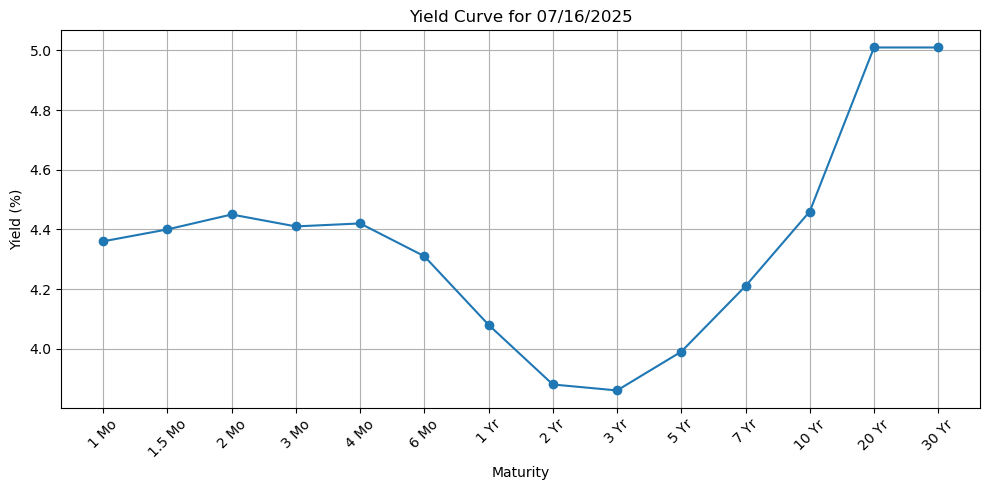

In [5]:
# Plotting the data
plt.figure(figsize=(10, 5))
plt.plot(date_7_16_2025.columns[1:], date_7_16_2025.iloc[0, 1:], marker='o')
plt.title('Yield Curve for 07/16/2025')
plt.xlabel('Maturity')
plt.ylabel('Yield (%)')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

### Data preparation

In [6]:
# def maturity in years
def convert_maturity_to_years(maturity):
    if 'Yr' in maturity:
        return float(maturity.replace('Yr', '').strip())
    elif 'Mo' in maturity:
        return float(maturity.replace('Mo', '').strip()) / 12

In [7]:
# transpose the data for better readability and remove date row and rename columns
data_7_16_2025 = date_7_16_2025.T
data_7_16_2025.columns = ['Yield %']
data_7_16_2025 = data_7_16_2025.iloc[1:]
data_7_16_2025.reset_index(inplace=True)
data_7_16_2025.rename(columns={'index': 'Maturity'}, inplace=True)

# Adding the 'Maturity' column as a numeric type as a new column. If Yr , then extract the number. If Mo, then convert to years dividing by 12.
data_7_16_2025['Maturity (Years)'] = round(data_7_16_2025['Maturity'].apply(convert_maturity_to_years),3)
data_7_16_2025

,Maturity,Yield %,Maturity (Years)
0,1 Mo,4.36,0.083
1,1.5 Mo,4.4,0.125
2,2 Mo,4.45,0.167
3,3 Mo,4.41,0.250
4,4 Mo,4.42,0.333
5,6 Mo,4.31,0.500
6,1 Yr,4.08,1.000
7,2 Yr,3.88,2.000
8,3 Yr,3.86,3.000
9,5 Yr,3.99,5.000


## Nelson Siegel Model

### Calibration using non linear curve fitting

In [8]:
# NS model calibration
def nelson_siegel_model(t, beta0, beta1, beta2, lambd):
    t = np.array(t)
    # Avoid division by zero for very small t
    t = np.where(t == 0, 1e-6, t)
    term1 = (1 - np.exp(-lambd * t)) / (lambd * t)
    term2 = term1 - np.exp(-lambd * t)
    return beta0 + beta1 * term1 + beta2 * term2

def objective(params, t, yields):
    beta0, beta1, beta2, lambd = params
    fitted = nelson_siegel_model(t, beta0, beta1, beta2, lambd)
    return np.sum((yields - fitted) ** 2)

In [21]:
yields

array([4.36, 4.4, 4.45, 4.41, 4.42, 4.31, 4.08, 3.88, 3.86, 3.99, 4.21,
       4.46, 5.01, 5.01], dtype=object)

In [24]:
maturities = data_7_16_2025["Maturity (Years)"].values
yields = data_7_16_2025["Yield %"].values

# Initial guess and bounds (length 4!)
initial_guess = [4.2, -1, 1, 0.5]
bounds = [(0, 8),   # beta0
          (-10, 10),   # beta1
          (-10, 10),   # beta2
          (0.001, 10)]  # lambd

# Fit using minimize
result = minimize(
    objective,
    initial_guess,
    args=(maturities, yields),
    bounds=bounds,
    method='L-BFGS-B',
    options={'maxiter': 10000}
)

# Extract results
beta0, beta1, beta2, lambd = result.x
print(f"Fitted parameters:")
print(f"beta0 = {beta0:.4f}")
print(f"beta1 = {beta1:.4f}")
print(f"beta2 = {beta2:.4f}")
print(f"lambda = {lambd:.4f}")

Fitted parameters:
beta0 = 5.4196
beta1 = -0.9010
beta2 = -3.6287
lambda = 0.4512


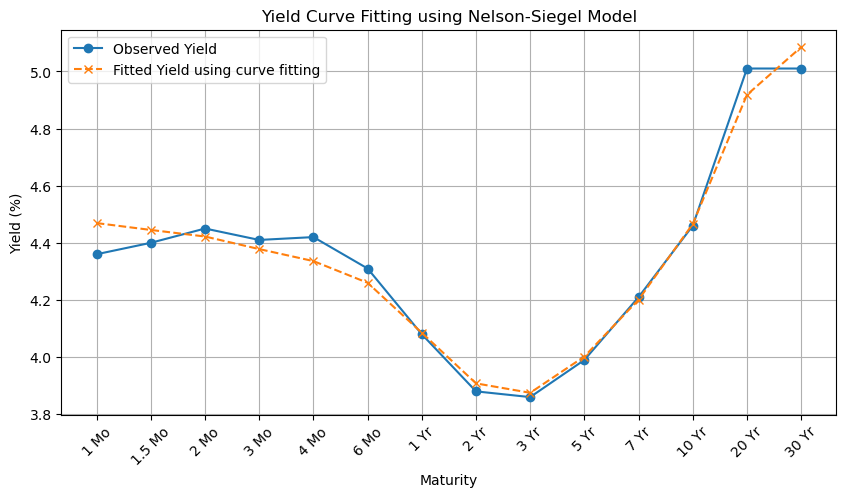

In [25]:
# Add fitted values to the DataFrame
data_7_16_2025['Fitted Yield % OLS(NS)'] = nelson_siegel_model(maturities, beta0, beta1, beta2, lambd)
# round the fitted values to 3 decimal places
data_7_16_2025['Fitted Yield % OLS(NS)'] = data_7_16_2025['Fitted Yield % OLS(NS)'].round(3)
# Plotting the original yields and fitted curve vs the maturities
plt.figure(figsize=(10, 5))
plt.plot(data_7_16_2025['Maturity'], data_7_16_2025['Yield %'], marker='o', label='Observed Yield')
plt.plot(data_7_16_2025['Maturity'], data_7_16_2025['Fitted Yield % OLS(NS)'], marker='x', linestyle='--', label='Fitted Yield using curve fitting')
plt.title('Yield Curve Fitting using Nelson-Siegel Model')
plt.xlabel('Maturity')
plt.ylabel('Yield (%)')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()


### Calibration using MLE

In [26]:
def neg_log_likelihood(params_mle, t, y):
    beta0_mle, beta1_mle, beta2_mle, lambd_mle, sigma_mle = params_mle
    y_hat = nelson_siegel_model(t, beta0_mle, beta1_mle, beta2_mle, lambd_mle)
    n = len(y)
    # NLL for Gaussian
    nll = 0.5 * n * np.log(2 * np.pi * sigma_mle ** 2) + 0.5 * np.sum((y - y_hat) ** 2) / sigma_mle ** 2
    return nll


In [27]:
initial_guess = [5.0, 1.0, 1.0, 0.1, 0.1]
bounds = [(-10, 20), (-20, 20), (-20, 20), (1e-6, 10), (1e-6, 2)]  # reasonable bounds

result = minimize(
    neg_log_likelihood,
    initial_guess,
    args=(maturities, yields),
    bounds=bounds,
    method='L-BFGS-B'
)

beta0_mle, beta1_mle, beta2_mle, lambd_mle, sigma_mle = result.x

print("Fitted parameters (MLE):")
print(f"beta0_mle = {beta0_mle:.4f}")
print(f"beta1_mle = {beta1_mle:.4f}")
print(f"beta2_mle = {beta2_mle:.4f}")
print(f"lambda_mle = {lambd_mle:.4f}")
print(f"sigma_mle = {sigma_mle:.4f}")

Fitted parameters (MLE):
beta0_mle = 5.4196
beta1_mle = -0.9010
beta2_mle = -3.6287
lambda_mle = 0.4512
sigma_mle = 0.0538


In [28]:
# adding fitted values to the DataFrame
data_7_16_2025['Fitted Yield % MLE (NS)'] = nelson_siegel_model(maturities, beta0_mle, beta1_mle, beta2_mle, lambd_mle)
# round the fitted values to 3 decimal places
data_7_16_2025['Fitted Yield % MLE (NS)'] = data_7_16_2025['Fitted Yield % MLE (NS)'].round(3)


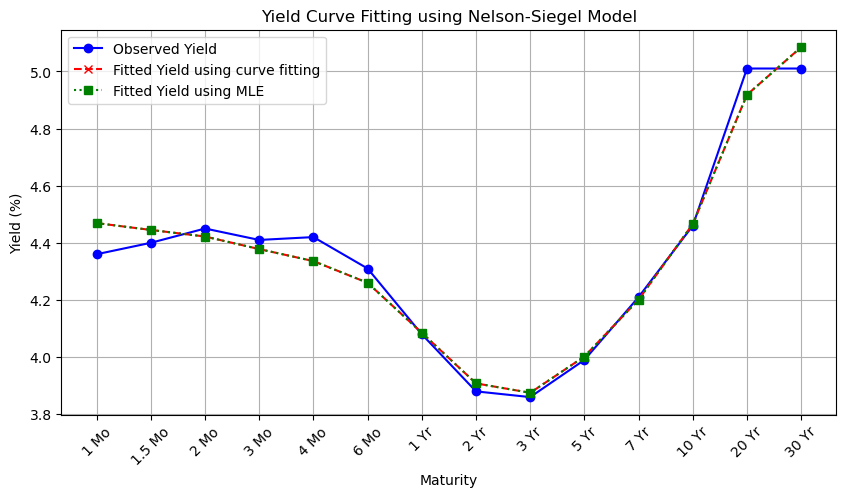

In [29]:
#plotting  original yields, fitted , MLE fitted vs maturities
plt.figure(figsize=(10, 5))
plt.plot(data_7_16_2025['Maturity'], data_7_16_2025['Yield %'], marker='o',color = 'b', label='Observed Yield')
plt.plot(data_7_16_2025['Maturity'], data_7_16_2025['Fitted Yield % OLS(NS)'], marker='x',color = 'r', linestyle='--', label='Fitted Yield using curve fitting')
plt.plot(data_7_16_2025['Maturity'], data_7_16_2025['Fitted Yield % MLE (NS)'], marker='s',color = 'g', linestyle=':', label='Fitted Yield using MLE')
plt.title('Yield Curve Fitting using Nelson-Siegel Model')
plt.xlabel('Maturity')
plt.ylabel('Yield (%)')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

### Why did we get the same optimized parameters for mle and non linear curve fitting?
Nonlinear curve fitting (least squares) and Maximum Likelihood Estimation (MLE) both solve for the parameters that best fit your data.

If you assume Gaussian (normal) errors, then minimizing sum of squared errors (SSE) (what curve fitting does) is mathematically equivalent to maximizing the likelihood (MLE).

So both methods, when applied correctly to the same model and data, will yield the same optimal parameters.

### Testing the data

In [30]:
# find the yeild for 1 Mo, 1.5 Mo, 2 Mo, 2.5 Mo, 3 Mo, 3.5 Mo, 4 Mo, 4.5 Mo, 5 Mo, 5.5 Mo, 6 Mo, 6.5 Mo, 7 Mo, 7.5 Mo, 8 Mo, 8.5 Mo, 9 Mo, 9.5 Mo, 10 Mo, 10.5 Mo, 11 Mo, 11.5 Mo, 12 Mo, 1 Yr, 2 Yr, 3 Yr, 4 Yr, 5 Yr, 6 Yr, 7 Yr, 8 Yr, 9 Yr, 10 Yr, 11 Yr, 12 Yr, 13 Yr, 14 Yr, 15 Yr, 16 Yr, 17 Yr, 18 Yr, 19 Yr, 20 Yr, 21 Yr, 22 Yr, 23 Yr, 24 Yr, 25 Yr, 26 Yr, 27 Yr, 28 Yr, 29 Yr, 30 Yr
maturities_to_check = [1/12, 1.5/12, 2/12, 2.5/12, 3/12, 3.5/12, 4/12, 4.5/12, 5/12, 5.5/12, 6/12, 6.5/12, 7/12, 7.5/12, 8/12, 8.5/12, 9/12, 9.5/12, 10/12, 10.5/12, 11/12, 11.5/12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
yields_to_check = nelson_siegel_model(maturities_to_check, beta0, beta1, beta2, lambd)
print("Yields for specific maturities:")
for maturity, yield_value in zip(maturities_to_check, yields_to_check):
    print(f"Maturity: {maturity:.2f} years, Yield: {yield_value:.4f} %")


Yields for specific maturities:
Maturity: 0.08 years, Yield: 4.4688 %
Maturity: 0.12 years, Yield: 4.4450 %
Maturity: 0.17 years, Yield: 4.4219 %
Maturity: 0.21 years, Yield: 4.3994 %
Maturity: 0.25 years, Yield: 4.3777 %
Maturity: 0.29 years, Yield: 4.3566 %
Maturity: 0.33 years, Yield: 4.3361 %
Maturity: 0.38 years, Yield: 4.3163 %
Maturity: 0.42 years, Yield: 4.2970 %
Maturity: 0.46 years, Yield: 4.2784 %
Maturity: 0.50 years, Yield: 4.2604 %
Maturity: 0.54 years, Yield: 4.2429 %
Maturity: 0.58 years, Yield: 4.2260 %
Maturity: 0.62 years, Yield: 4.2096 %
Maturity: 0.67 years, Yield: 4.1938 %
Maturity: 0.71 years, Yield: 4.1785 %
Maturity: 0.75 years, Yield: 4.1637 %
Maturity: 0.79 years, Yield: 4.1494 %
Maturity: 0.83 years, Yield: 4.1356 %
Maturity: 0.88 years, Yield: 4.1223 %
Maturity: 0.92 years, Yield: 4.1094 %
Maturity: 0.96 years, Yield: 4.0970 %
Maturity: 1.00 years, Yield: 4.0850 %
Maturity: 2.00 years, Yield: 3.9077 %
Maturity: 3.00 years, Yield: 3.8749 %
Maturity: 4.00 yea

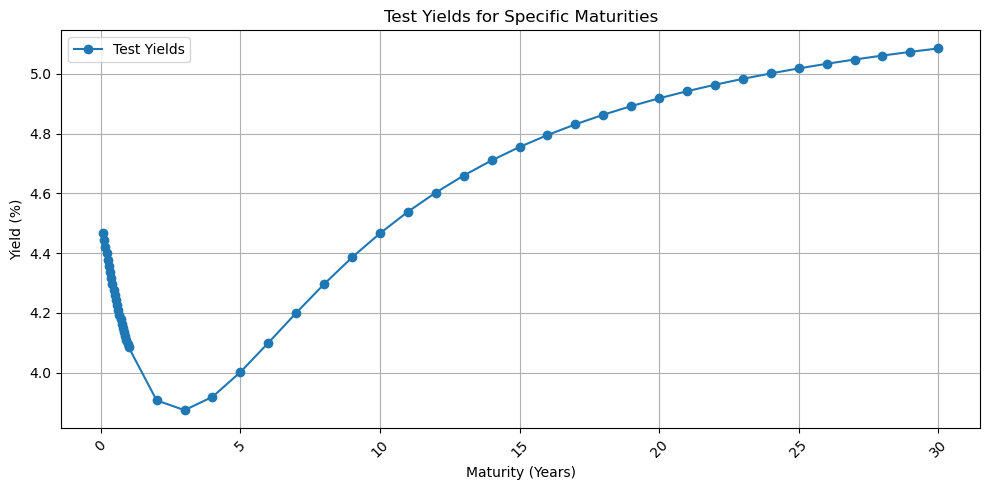

In [31]:
# plot the test yields with yields number on each point with equal spacing and the values not clashing on each other
plt.figure(figsize=(10, 5))
plt.plot(maturities_to_check, yields_to_check, marker='o', label='Test Yields')

plt.title('Test Yields for Specific Maturities')
plt.xlabel('Maturity (Years)')
plt.ylabel('Yield (%)')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


In [32]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=maturities_to_check,
    y=yields_to_check,
    mode='markers+lines',
    name='Test Yields',
    marker=dict(size=8)
))

fig.update_layout(
    title='Test Yields for Specific Maturities',
    xaxis_title='Maturity (Years)',
    yaxis_title='Yield (%)',
    xaxis=dict(tickangle=45),
    legend=dict(x=0.01, y=0.99),
    template='plotly_dark',  # <-- set background to black
    width=900,
    height=400
)

## Nelson Siegel Svensson Model

In [33]:
def nelson_siegel_svensson_model(t, beta0, beta1, beta2, beta3, lambd1, lambd2):
    t = np.array(t)
    # Avoid division by zero for very small t
    t = np.where(t == 0, 1e-6, t)
    term1 = (1 - np.exp(-lambd1 * t)) / (lambd1 * t)
    term2 = term1 - np.exp(-lambd1 * t)
    term3 = ((1 - np.exp(-lambd2 * t)) / (lambd2 * t)) - np.exp(-lambd2 * t)
    return beta0 + beta1 * term1 + beta2 * term2 + beta3 * term3


In [34]:
def objective(params, t, yields):
    beta0, beta1, beta2, beta3, lambd1, lambd2 = params
    fitted = nelson_siegel_svensson_model(t, beta0, beta1, beta2, beta3, lambd1, lambd2)
    return np.sum((yields - fitted) ** 2)

In [72]:
maturities = data_7_16_2025["Maturity (Years)"].values
yields = data_7_16_2025["Yield %"].values

# Initial guess: beta0, beta1, beta2, beta3, lambd1, lambd2
initial_guess = [5.4, 1.0, 1.0, 1.0, 0.5, 0.5]

# For NSS (6 parameters: beta0, beta1, beta2, beta3, lambd1, lambd2)
bounds = [(3, 6),  # beta0
          (-10, 10),  # beta1
          (-10, 10),  # beta2
          (-10, 10),  # beta3
          (0.001, 10), # lambd1
          (0.001, 10)] # lambd2


# Fit using minimize
result = minimize(
    objective,
    initial_guess,
    args=(maturities, yields),
    bounds=bounds,
    method='L-BFGS-B',
    options={'maxiter': 10000}
)


beta0, beta1, beta2, beta3, lambd1, lambd2 = result.x

print(f"Fitted parameters:")
print(f"beta0  = {beta0:.4f}")
print(f"beta1  = {beta1:.4f}")
print(f"beta2  = {beta2:.4f}")
print(f"beta3  = {beta3:.4f}")
print(f"lambda1 = {lambd1:.4f}")
print(f"lambda2 = {lambd2:.4f}")

Fitted parameters:
beta0  = 5.3432
beta1  = -0.9729
beta2  = -0.0001
beta3  = -4.8305
lambda1 = 3.8886
lambda2 = 0.5834


In [73]:
# Add fitted values to the DataFrame
data_7_16_2025['Fitted Yield % OLS(NSS)'] = nelson_siegel_svensson_model(maturities, beta0, beta1, beta2, beta3, lambd1, lambd2)
# round the fitted values to 3 decimal places
data_7_16_2025['Fitted Yield % OLS(NSS)'] = data_7_16_2025['Fitted Yield % OLS(NSS)'].round(3)

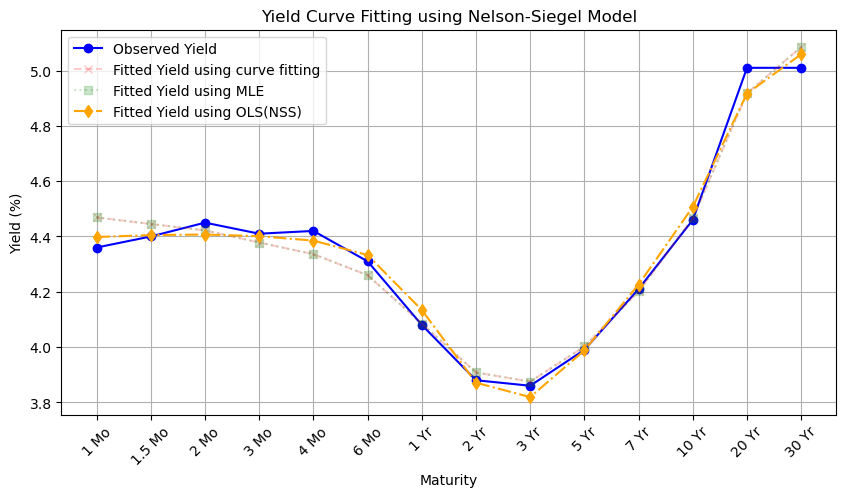

In [74]:
#plotting  original yields, fitted , MLE fitted vs maturities
plt.figure(figsize=(10, 5))
plt.plot(data_7_16_2025['Maturity'], data_7_16_2025['Yield %'], marker='o',color = 'b', label='Observed Yield')
plt.plot(data_7_16_2025['Maturity'], data_7_16_2025['Fitted Yield % OLS(NS)'], marker='x',color = 'r', linestyle='--', label='Fitted Yield using curve fitting',alpha=0.2)
plt.plot(data_7_16_2025['Maturity'], data_7_16_2025['Fitted Yield % MLE (NS)'], marker='s',color = 'g', linestyle=':', label='Fitted Yield using MLE', alpha=0.2)
plt.plot(data_7_16_2025['Maturity'], data_7_16_2025['Fitted Yield % OLS(NSS)'], marker='d', color='orange', linestyle='-.', label='Fitted Yield using OLS(NSS)')
plt.title('Yield Curve Fitting using Nelson-Siegel Model')
plt.xlabel('Maturity')
plt.ylabel('Yield (%)')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

### Testing the data

In [43]:
# find the yeild for 1 Mo, 1.5 Mo, 2 Mo, 2.5 Mo, 3 Mo, 3.5 Mo, 4 Mo, 4.5 Mo, 5 Mo, 5.5 Mo, 6 Mo, 6.5 Mo, 7 Mo, 7.5 Mo, 8 Mo, 8.5 Mo, 9 Mo, 9.5 Mo, 10 Mo, 10.5 Mo, 11 Mo, 11.5 Mo, 12 Mo, 1 Yr, 2 Yr, 3 Yr, 4 Yr, 5 Yr, 6 Yr, 7 Yr, 8 Yr, 9 Yr, 10 Yr, 11 Yr, 12 Yr, 13 Yr, 14 Yr, 15 Yr, 16 Yr, 17 Yr, 18 Yr, 19 Yr, 20 Yr, 21 Yr, 22 Yr, 23 Yr, 24 Yr, 25 Yr, 26 Yr, 27 Yr, 28 Yr, 29 Yr, 30 Yr
maturities_to_check = [1/12, 1.5/12, 2/12, 2.5/12, 3/12, 3.5/12, 4/12, 4.5/12, 5/12, 5.5/12, 6/12, 6.5/12, 7/12, 7.5/12, 8/12, 8.5/12, 9/12, 9.5/12, 10/12, 10.5/12, 11/12, 11.5/12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
yields_to_check = nelson_siegel_svensson_model(maturities_to_check, beta0, beta1, beta2, beta3, lambd1, lambd2)
print("Yields for specific maturities:")
for maturity, yield_value in zip(maturities_to_check, yields_to_check):
    print(f"Maturity: {maturity:.2f} years, Yield: {yield_value:.4f} %")

Yields for specific maturities:
Maturity: 0.08 years, Yield: 4.4688 %
Maturity: 0.12 years, Yield: 4.4450 %
Maturity: 0.17 years, Yield: 4.4219 %
Maturity: 0.21 years, Yield: 4.3994 %
Maturity: 0.25 years, Yield: 4.3777 %
Maturity: 0.29 years, Yield: 4.3566 %
Maturity: 0.33 years, Yield: 4.3361 %
Maturity: 0.38 years, Yield: 4.3163 %
Maturity: 0.42 years, Yield: 4.2970 %
Maturity: 0.46 years, Yield: 4.2784 %
Maturity: 0.50 years, Yield: 4.2604 %
Maturity: 0.54 years, Yield: 4.2429 %
Maturity: 0.58 years, Yield: 4.2260 %
Maturity: 0.62 years, Yield: 4.2096 %
Maturity: 0.67 years, Yield: 4.1938 %
Maturity: 0.71 years, Yield: 4.1785 %
Maturity: 0.75 years, Yield: 4.1637 %
Maturity: 0.79 years, Yield: 4.1494 %
Maturity: 0.83 years, Yield: 4.1356 %
Maturity: 0.88 years, Yield: 4.1223 %
Maturity: 0.92 years, Yield: 4.1094 %
Maturity: 0.96 years, Yield: 4.0970 %
Maturity: 1.00 years, Yield: 4.0850 %
Maturity: 2.00 years, Yield: 3.9077 %
Maturity: 3.00 years, Yield: 3.8749 %
Maturity: 4.00 yea

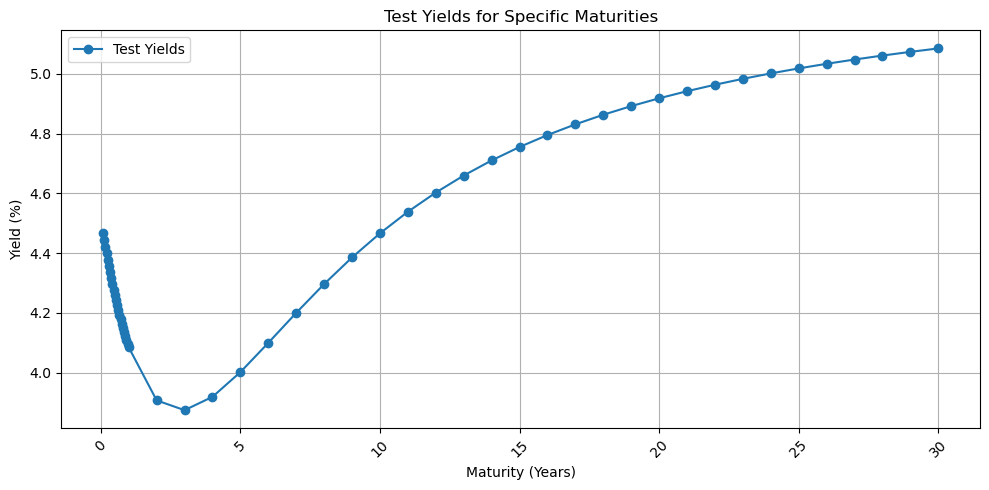

In [44]:
# plot the test yields with yields number on each point with equal spacing and the values not clashing on each other
plt.figure(figsize=(10, 5))
plt.plot(maturities_to_check, yields_to_check, marker='o', label='Test Yields')

plt.title('Test Yields for Specific Maturities')
plt.xlabel('Maturity (Years)')
plt.ylabel('Yield (%)')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [45]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=maturities_to_check,
    y=yields_to_check,
    mode='markers+lines',
    name='Test Yields',
    marker=dict(size=8)
))

fig.update_layout(
    title='Test Yields for Specific Maturities',
    xaxis_title='Maturity (Years)',
    yaxis_title='Yield (%)',
    xaxis=dict(tickangle=45),
    legend=dict(x=0.01, y=0.99),
    template='plotly_dark',  # <-- set background to black
    width=900,
    height=400
)